# UniProt Sequence Coverage by 3D Structures in PDB

This notebook determines the coverage of UniProtKB sequences on a per protein chain basis for protein structures in the PDB.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Get UniProtKB Data
UniProt id, preferred gene name, and sequence length ([see column names for RESTful web services](https://www.uniprot.org/help/uniprotkb_column_names)).

In [2]:
taxonomy_id = 9606
taxonomy_id = 2697049
columns = 'id,genes(PREFERRED),length'

In [3]:
url = f'https://www.uniprot.org/uniprot/?query=organism:{taxonomy_id}&columns={columns}&format=tab'

In [22]:
unp = pd.read_csv(url, sep='\t')
unp.rename(columns={'Gene names  (primary )': 'GENE'}, inplace=True)  ## create name without spaces
unp.head(1000)

,Entry,GENE,Length
0,P0DTC2,S,1273
1,P0DTC9,N,419
2,P0DTC1,NaN,4405
3,P0DTC7,NaN,121
4,P0DTD2,NaN,97
...,...,...,...
115,A0A679G9E9,S,1273
116,A0A6C0NA72,M,222
117,A0A6B9VKN0,orf8,121
118,A0A6C0N6C6,orf8,121


In [5]:
print('Unique proteins: ', len(unp['Entry'].unique()), 'for organism:', taxonomy_id)
print('Unique genes   : ', len(unp['GENE'].unique()), 'for organism:', taxonomy_id)

Unique proteins:  120 for organism: 2697049
Unique genes   :  20 for organism: 2697049


## Get UniProt segments covered by PDB residues
Get continuous segments of the UniProt sequence covered by PDB residues from EBI [SIFTS](https://www.ebi.ac.uk/pdbe/docs/sifts/) project.

In [8]:
sifts_url = 'http://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/uniprot_segments_observed.tsv.gz'

In [9]:
segments = pd.read_csv(sifts_url, sep='\t', skiprows=1)
segments.head()

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
0,128l,A,P00720,1,162,1,162,1,162
1,113l,A,P00720,1,162,1,162,1,162
2,123l,A,P00720,1,162,1,162,1,162
3,105m,A,P02185,1,153,1,153,2,154
4,120l,A,P00720,1,162,1,162,1,162


Calculate length of each continuous segment. A chain may have one or more segments.

In [10]:
segments['SEG_LENGTH'] = segments['SP_END'] - segments['SP_BEG'] + 1

Create a unique key for each chain. Use upper case for PDB IDs. Note, Chain IDs are case sensitive!

In [11]:
segments['PDB_CHAIN_ID'] = segments['PDB'].str.upper()  + "." + segments['CHAIN']
segments = segments[['PDB_CHAIN_ID','SP_PRIMARY','SP_BEG','SP_END','SEG_LENGTH']]

In [12]:
segments.head()

,PDB_CHAIN_ID,SP_PRIMARY,SP_BEG,SP_END,SEG_LENGTH
0,128L.A,P00720,1,162,162
1,113L.A,P00720,1,162,162
2,123L.A,P00720,1,162,162
3,105M.A,P02185,2,154,153
4,120L.A,P00720,1,162,162


## Create the intersection between the two dataframes

In [13]:
coverage = segments.merge(unp, left_on=['SP_PRIMARY'], right_on=['Entry'])

Calculate the coverage per segment.

In [14]:
coverage['coverage'] = coverage['SEG_LENGTH'] / coverage['Length']
coverage.head()

,PDB_CHAIN_ID,SP_PRIMARY,SP_BEG,SP_END,SEG_LENGTH,Entry,GENE,Length,coverage
0,5RE9.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841
1,5REE.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841
2,5REN.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841
3,5REI.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841
4,5REW.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841


Sum up the coverage for each unique chain.

In [15]:
chain_cov = coverage.groupby(['PDB_CHAIN_ID','SP_PRIMARY','GENE']).sum()[['coverage']]
chain_cov = chain_cov[(chain_cov['coverage'] <= 1.0)]  # there are a few cases where coverage > 1 (e.g., P69905, P01579, Q15848)
chain_cov = chain_cov.reset_index()  # convert grouped dataframe to a regular dataframe
chain_cov.head()

,PDB_CHAIN_ID,SP_PRIMARY,GENE,coverage
0,5R7Y.A,P0DTD1,rep,0.042841
1,5R7Z.A,P0DTD1,rep,0.042841
2,5R80.A,P0DTD1,rep,0.042841
3,5R81.A,P0DTD1,rep,0.042841
4,5R82.A,P0DTD1,rep,0.042841


In [16]:
print('Unique chains    :', chain_cov.shape[0])
print('Unique proteins  :', len(chain_cov['SP_PRIMARY'].unique()))
print('Unique genes     :', len(chain_cov['GENE'].unique()))
print('Average coverage :', chain_cov['coverage'].mean())
print('Median coverage  :', chain_cov['coverage'].median())

Unique chains    : 445
Unique proteins  : 3
Unique genes     : 3
Average coverage : 0.16205190230276845
Median coverage  : 0.04284103720405862


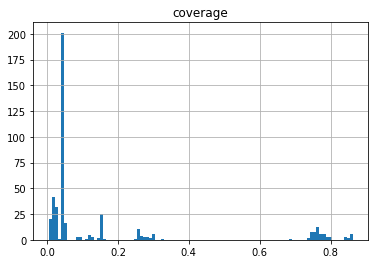

In [17]:
chain_cov.hist(bins=100);

In [18]:
coverage['pdbId'] = coverage['PDB_CHAIN_ID'].str[:4]

In [19]:
coverage.head()

,PDB_CHAIN_ID,SP_PRIMARY,SP_BEG,SP_END,SEG_LENGTH,Entry,GENE,Length,coverage,pdbId
0,5RE9.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841,5RE9
1,5REE.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841,5REE
2,5REN.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841,5REN
3,5REI.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841,5REI
4,5REW.A,P0DTD1,3264,3567,304,P0DTD1,rep,7096,0.042841,5REW


In [20]:
len(coverage['pdbId'].unique())

271

In [21]:
coverage['SP_PRIMARY'].unique()

array(['P0DTD1', 'P0DTC9', 'P0DTC2', 'P0DTC1', 'P0DTC7', 'P0DTD2',
       'P0DTC3'], dtype=object)

In [ ]:
coverage.info()